# CAB420, Week 4 Practical, Question 1 Solution
## Kuzushiji-MNIST and Kuzushiji-MNIST-49

The Kuzushiji-MNIST database is a MNIST like database based on Japanese Kuzushiji characters. Following the pattern of MNIST, it contains gresyscale images of size 28x28 pixels for 10 Kuzushiji characters. A second expanded dataset, Kuzushiji-MNIST-49, has the same format but 49 different characters. The dataset is also imbalanced, in that not every class has the same number of instances and some classes are rarer than others. Using these two datasets:
* Create and train a network to classify the Kuzushiji-MNIST database into it's 10 classes. Evaluate the network on the test set.
* Extend the network to classify the Kuzushiji-MNIST-49 dataset into it's 49 classes. Evaluate the network on the test set, and consider the frequency with which each class occurs when analysing results.

Note that you do not need to try to make your networks overly complex, or train them for more than a few minutes. Smaller networks and training times of 5-10 epochs will be sufficient for this practical. However you are encouraged to experiment with different architectures and explore how they impact performance.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# function to compute class weights
from sklearn.utils import compute_class_weight

import matplotlib.pyplot as plt

import scipy.io
import numpy

## Part 1: K-MNIST
Data loading. Using scipy to load the data

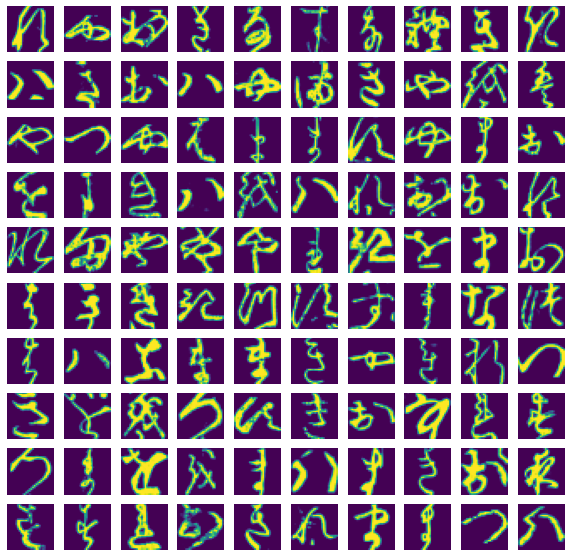

In [2]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist_test.mat')

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(kmnist_train['imgs'][:,:,i])
    ax.axis('off')    

Have a quick look at the data. It's always good to make sure we have what we expect.

In [3]:
print(numpy.shape(kmnist_train['imgs']))
print(kmnist_train['imgs'][:,:,1])
print(numpy.shape(kmnist_train['labels']))

(28, 28, 50000)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

We need to reshape our data so such that the first index is the sample index, and convert it into a 4D structure

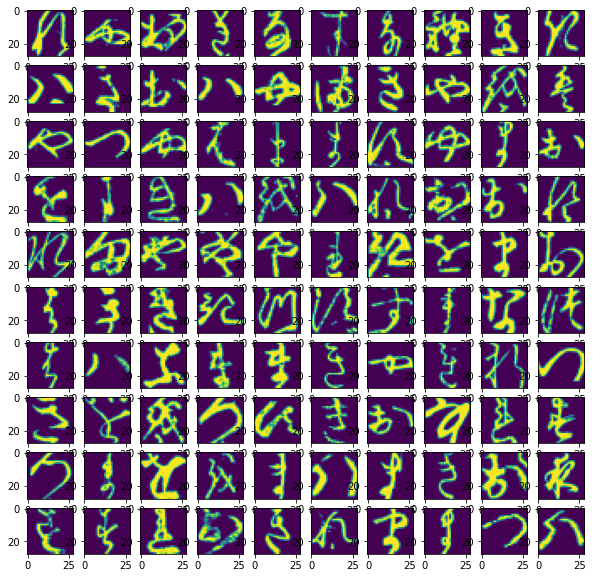

In [4]:
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])

### The Network

This is taken from ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb``.

I've defined the number of training epochs here as (essentially) a global constant. This is based on running this on my laptio. You may want to adapt this depending on your own comptue environment.

In [5]:
num_epochs = 10

# function to build a model, takes the number of classes. Can optionally change the output activation. 
# See the discussion at bottom of this script for more details about that.
def build_model(num_classes, output_activation=None):
    # our model, input in an image shape
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    # we'll use a couple of dense layers here, mainly so that we can show what another dropout layer looks like 
    # in the middle
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='kmnist_cnn_model')
    
    return model_cnn

model_cnn = build_model(10)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)    

### Train the model

We're only going to train for 10 epochs. This could easily run longer, but for the sake of speed we'll keep it short.

In [6]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Epoch 1/10
391/391 [==============================] - 15s 27ms/step - loss: 0.7096 - accuracy: 0.7684 - val_loss: 0.4960 - val_accuracy: 0.8393
Epoch 2/10
391/391 [==============================] - 10s 25ms/step - loss: 0.2764 - accuracy: 0.9156 - val_loss: 0.3397 - val_accuracy: 0.9017
Epoch 3/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1959 - accuracy: 0.9409 - val_loss: 0.2863 - val_accuracy: 0.9176
Epoch 4/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1546 - accuracy: 0.9532 - val_loss: 0.2566 - val_accuracy: 0.9257
Epoch 5/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1300 - accuracy: 0.9618 - val_loss: 0.2204 - val_accuracy: 0.9377
Epoch 6/10
391/391 [==============================] - 10s 25ms/step - loss: 0.1143 - accuracy: 0.9672 - val_loss: 0.2189 - val_accuracy: 0.9362
Epoch 7/10
391/391 [==============================] - 10s 26ms/step - loss: 0.1004 - accuracy: 0.9694 - val_loss: 0.1993 - val_accuracy:

### Evaluate the Results

As per the lecture example, we have an eval function to show what's going on.

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1000
           1       0.97      0.91      0.94      1000
           2       0.95      0.90      0.92      1000
           3       0.95      0.99      0.97      1000
           4       0.92      0.93      0.93      1000
           5       0.98      0.94      0.96      1000
           6       0.92      0.97      0.94      1000
           7       0.98      0.96      0.97      1000
           8       0.92      0.97      0.94      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



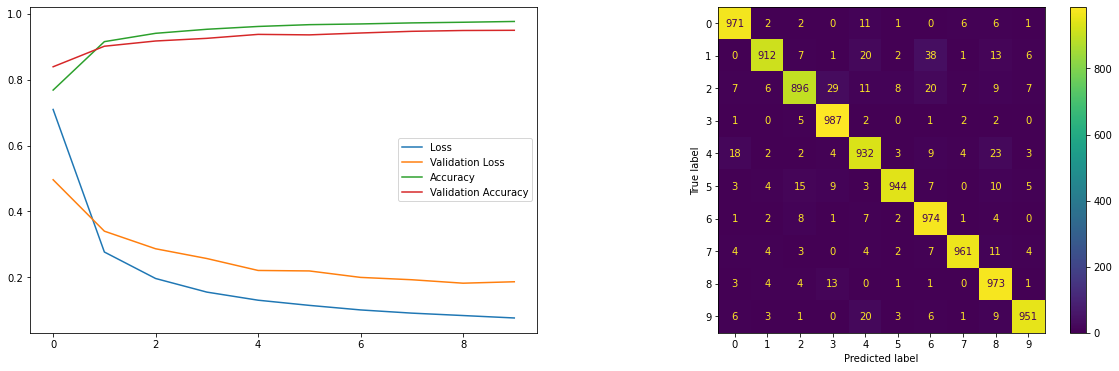

In [7]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[20, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    c = ConfusionMatrixDisplay(cm, display_labels=range(len(numpy.unique(y_test))))
    c.plot(ax = ax)
    
    print(classification_report(y_test, indexes))

eval_model(model_cnn, history.history, train, train_y, test, test_y)

We can see a few things from the above training and evaluation:
* Performance is fairly consistent across all classes
* Classes are evenly distributed, i.e. we have no imbalance

## Part 2: K-MNIST 49
We'll repeat now using the 49 class version of the data. This largely follows the above part 1.

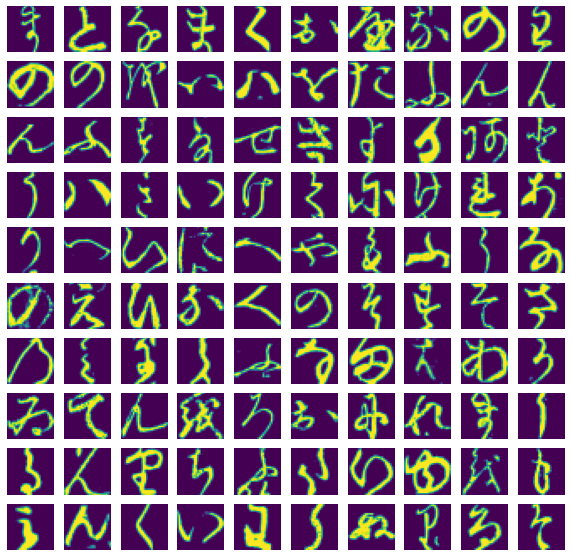

In [8]:
kmnist_train = scipy.io.loadmat('../../data/kmnist/kmnist49_train.mat')
kmnist_test = scipy.io.loadmat('../../data/kmnist/kmnist49_test.mat')
train = numpy.transpose(kmnist_train['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
train_y = kmnist_train['labels']
test = numpy.transpose(kmnist_test['imgs'], (2, 0, 1)).reshape(-1, 28, 28, 1)
test_y = kmnist_test['labels']

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')

### The Model
Exactly the same as last time - that's why I created a function for it. We're just going to increase the number of classes to 49 to match the different dataset.

In [9]:
model_cnn = build_model(49)
model_cnn.summary()

Model: "kmnist_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
activation_3 (Activation)    (None, 28, 28, 8)         0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)    

In [10]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y))

Epoch 1/10
1816/1816 [==============================] - 47s 25ms/step - loss: 1.2337 - accuracy: 0.6694 - val_loss: 0.7232 - val_accuracy: 0.8068
Epoch 2/10
1816/1816 [==============================] - 45s 25ms/step - loss: 0.5654 - accuracy: 0.8448 - val_loss: 0.5134 - val_accuracy: 0.8610
Epoch 3/10
1816/1816 [==============================] - 45s 25ms/step - loss: 0.4369 - accuracy: 0.8801 - val_loss: 0.4224 - val_accuracy: 0.8869
Epoch 4/10
1816/1816 [==============================] - 45s 25ms/step - loss: 0.3707 - accuracy: 0.8977 - val_loss: 0.3779 - val_accuracy: 0.8986
Epoch 5/10
1816/1816 [==============================] - 50s 27ms/step - loss: 0.3324 - accuracy: 0.9075 - val_loss: 0.3488 - val_accuracy: 0.9064
Epoch 6/10
1816/1816 [==============================] - 53s 29ms/step - loss: 0.3024 - accuracy: 0.9161 - val_loss: 0.3328 - val_accuracy: 0.9129
Epoch 7/10
1816/1816 [==============================] - 53s 29ms/step - loss: 0.2818 - accuracy: 0.9220 - val_loss: 0.3031 -

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.97      0.97      0.97      1000
           2       0.88      0.96      0.92      1000
           3       0.88      0.89      0.89       126
           4       0.94      0.96      0.95      1000
           5       0.89      0.90      0.89      1000
           6       0.94      0.91      0.92      1000
           7       0.91      0.92      0.91      1000
           8       0.88      0.92      0.90       767
           9       0.95      0.94      0.94      1000
          10       0.97      0.95      0.96      1000
          11       0.93      0.94      0.94      1000
          12       0.92      0.89      0.90      1000
          13       0.94      0.87      0.90       678
          14       0.87      0.82      0.84       629
          15       0.97      0.94      0.95      1000
          16       0.97      0.97      0.97       418
          17       0.93    

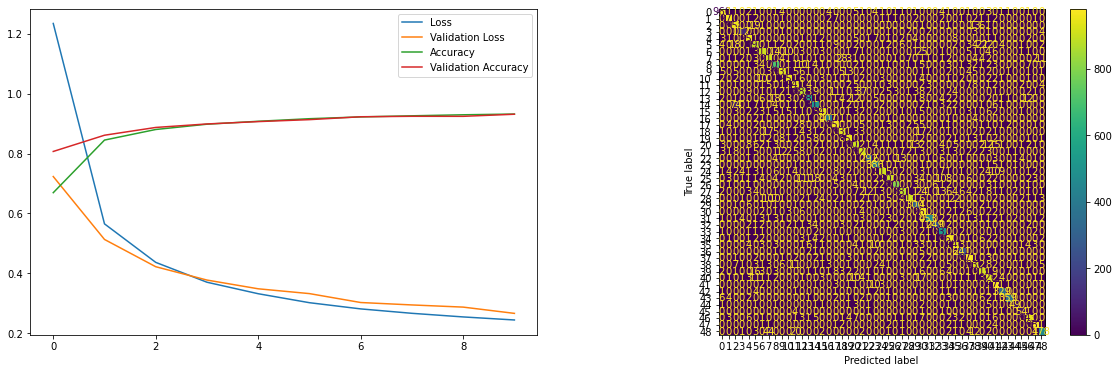

In [11]:
eval_model(model_cnn, history.history, train, train_y, test, test_y)

The model works ok, but we have massive class imbalance (see below). Our network actually performs quite well in the presence of this, yet all the same let's add some class weights in and see what happens.

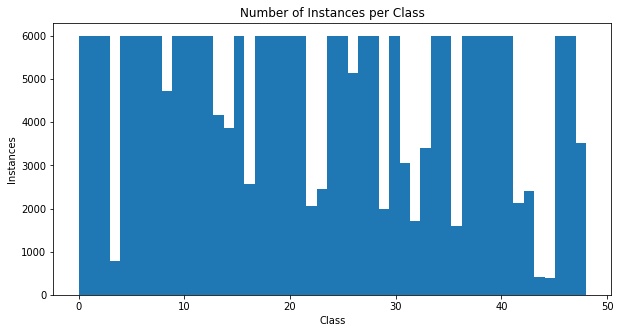

In [12]:
fig = plt.figure(figsize=[10, 5])    
ax = fig.add_subplot(1, 1, 1)
ax.hist(train_y.flatten(), 49)
ax.set_xlabel('Class')
ax.set_ylabel('Instances')
ax.set_title('Number of Instances per Class');

### Adjusting Class Weights

We can use sklean to get the class weight for us, though we need to convert them into a dictionary for keras.

In [13]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=numpy.unique(train_y.flatten()),
                                     y=train_y.flatten())
print(class_weights)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

[ 0.79035714  0.79035714  0.79035714  6.10314396  0.79035714  0.79035714
  0.79035714  0.79035714  1.00597006  0.79035714  0.79035714  0.79035714
  0.79035714  1.13856971  1.22631054  0.79035714  1.84878864  0.79035714
  0.79035714  0.79035714  0.79035714  0.79035714  2.29866353  1.93477881
  0.79035714  0.79035714  0.92403407  0.79035714  0.79035714  2.37939933
  0.79035714  1.54971989  2.76026942  1.39721357  0.79035714  0.79035714
  2.96754872  0.79035714  0.79035714  0.79035714  0.79035714  0.79035714
  2.21699058  1.97836581 11.37204522 12.09730321  0.79035714  0.79035714
  1.34605247]
{0: 0.7903571428571429, 1: 0.7903571428571429, 2: 0.7903571428571429, 3: 6.103143960286817, 4: 0.7903571428571429, 5: 0.7903571428571429, 6: 0.7903571428571429, 7: 0.7903571428571429, 8: 1.005970058791442, 9: 0.7903571428571429, 10: 0.7903571428571429, 11: 0.7903571428571429, 12: 0.7903571428571429, 13: 1.1385697135997257, 14: 1.2263105397317966, 15: 0.7903571428571429, 16: 1.8487886382623224, 17: 0

Comparing the class weights to the histogram above, we see that these make a lot of sense. Classes that were comparitively small have a high weight, those with lots of examples have a low weight.

We can pass that info directly to the model.fit call and use that to help train the model.

In [14]:
model_cnn = build_model(49)
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [15]:
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights_dict)

Epoch 1/10
1816/1816 [==============================] - 63s 35ms/step - loss: 1.3840 - accuracy: 0.6257 - val_loss: 0.8906 - val_accuracy: 0.7630
Epoch 2/10
1816/1816 [==============================] - 63s 35ms/step - loss: 0.6502 - accuracy: 0.8164 - val_loss: 0.6271 - val_accuracy: 0.8296
Epoch 3/10
1816/1816 [==============================] - 63s 35ms/step - loss: 0.4945 - accuracy: 0.8592 - val_loss: 0.5096 - val_accuracy: 0.8632
Epoch 4/10
1816/1816 [==============================] - 64s 35ms/step - loss: 0.4181 - accuracy: 0.8810 - val_loss: 0.4535 - val_accuracy: 0.8774
Epoch 5/10
1816/1816 [==============================] - 65s 36ms/step - loss: 0.3687 - accuracy: 0.8944 - val_loss: 0.4039 - val_accuracy: 0.8915
Epoch 6/10
1816/1816 [==============================] - 66s 36ms/step - loss: 0.3349 - accuracy: 0.9029 - val_loss: 0.3740 - val_accuracy: 0.8994
Epoch 7/10
1816/1816 [==============================] - 66s 36ms/step - loss: 0.3123 - accuracy: 0.9103 - val_loss: 0.3646 -

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1000
           1       0.99      0.96      0.97      1000
           2       0.90      0.96      0.93      1000
           3       0.75      0.93      0.83       126
           4       0.95      0.93      0.94      1000
           5       0.90      0.87      0.89      1000
           6       0.95      0.86      0.90      1000
           7       0.92      0.90      0.91      1000
           8       0.81      0.92      0.86       767
           9       0.95      0.92      0.93      1000
          10       0.96      0.94      0.95      1000
          11       0.94      0.94      0.94      1000
          12       0.93      0.87      0.90      1000
          13       0.92      0.80      0.86       678
          14       0.88      0.84      0.86       629
          15       0.95      0.95      0.95      1000
          16       0.90      0.99      0.94       418
          17       0.91    

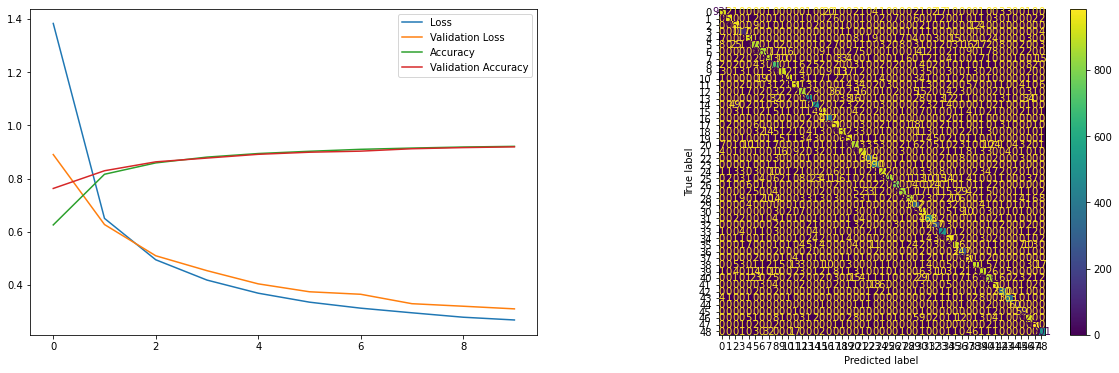

In [16]:
eval_model(model_cnn, history.history, train, train_y, test, test_y)

Training that network again, we see that our performance is similar to before, but has dropped a bit (in overall terms) over what we had above. Remembering back to what we saw when using class weights with SVMs, this is not surprising. By using the class weights we aim to improve performance for classes we have few instances of; at the possible cost of classes that we have lots of data for.

What this means is that we tend to make more errors on the really common classes, and because those classes are really common, we make more errors overall. Looking at the classification report, we see that for the really rare classes (those with a lower value in support), we've improved somewhat, but in general we're still struggling here. For the ones that we have a moderate amount of data for, we've typically improved a bit, and we've dropped a little bit for some of the more common classes.

## A Note on SparseCategoricalCrossentropy

In the approach presented above we've taken a shortcut - we just use our training labels as is and don't actually force it into a one-hot representation. But we still have this in our output. What gives?

Keras allows us to feed in the labels and let the loss function sort out the one hot representation for us, provide we use the loss function we've been using:
`keras.losses.SparseCategoricalCrossentropy(from_logits=True),`

When ``from_logits=True``, this is also assuming that we've got no softmax activation on our final layer. If we have a softmax activation, we should set ``from_logits=False``.

The other option is to convert the data to a one-hot representation and work with that. We'll quickly look at how to do that now.

The first thing that we'll do is convert out labels, and helpfully there's a keras function for this.

In [17]:
from tensorflow.keras.utils import to_categorical

train_y = to_categorical(kmnist_train['labels'], 49)
test_y = to_categorical(kmnist_test['labels'], 49)

From this point we'll pretty much continue as per our last attempt, so we'll use class weights again.

We have two changes to make now:
* Our final layer (the output) needs to have a soft-max activation
* Our loss needs to change. We now have a genuine one-hot representation, so we can use the standard categorical_crossentropy.

In [18]:
model_cnn = build_model(49, 'softmax')
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=num_epochs,
                        validation_data=(test, test_y), 
                        class_weight=class_weights_dict)

Epoch 1/10
1816/1816 [==============================] - 69s 37ms/step - loss: 1.3472 - accuracy: 0.6357 - val_loss: 0.8685 - val_accuracy: 0.7723
Epoch 2/10
1816/1816 [==============================] - 66s 36ms/step - loss: 0.6315 - accuracy: 0.8221 - val_loss: 0.6150 - val_accuracy: 0.8345
Epoch 3/10
1816/1816 [==============================] - 66s 36ms/step - loss: 0.4868 - accuracy: 0.8611 - val_loss: 0.4933 - val_accuracy: 0.8649
Epoch 4/10
1816/1816 [==============================] - 66s 36ms/step - loss: 0.4095 - accuracy: 0.8827 - val_loss: 0.4216 - val_accuracy: 0.8854
Epoch 5/10
1816/1816 [==============================] - 65s 36ms/step - loss: 0.3580 - accuracy: 0.8966 - val_loss: 0.3864 - val_accuracy: 0.8952
Epoch 6/10
1816/1816 [==============================] - 66s 36ms/step - loss: 0.3299 - accuracy: 0.9043 - val_loss: 0.3632 - val_accuracy: 0.9007
Epoch 7/10
1816/1816 [==============================] - 67s 37ms/step - loss: 0.3110 - accuracy: 0.9100 - val_loss: 0.3348 -

We need to modify our eval_model function slightly to deal with the different data type for our test labels.

While we're at it, we can improve the figure size.

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1000
           1       0.98      0.96      0.97      1000
           2       0.92      0.96      0.94      1000
           3       0.54      0.97      0.70       126
           4       0.95      0.94      0.94      1000
           5       0.93      0.85      0.89      1000
           6       0.96      0.86      0.91      1000
           7       0.94      0.87      0.90      1000
           8       0.86      0.93      0.89       767
           9       0.95      0.93      0.94      1000
          10       0.94      0.95      0.95      1000
          11       0.95      0.92      0.93      1000
          12       0.92      0.86      0.89      1000
          13       0.94      0.85      0.89       678
          14       0.85      0.88      0.86       629
          15       0.94      0.95      0.95      1000
          16       0.93      0.98      0.95       418
          17       0.91    

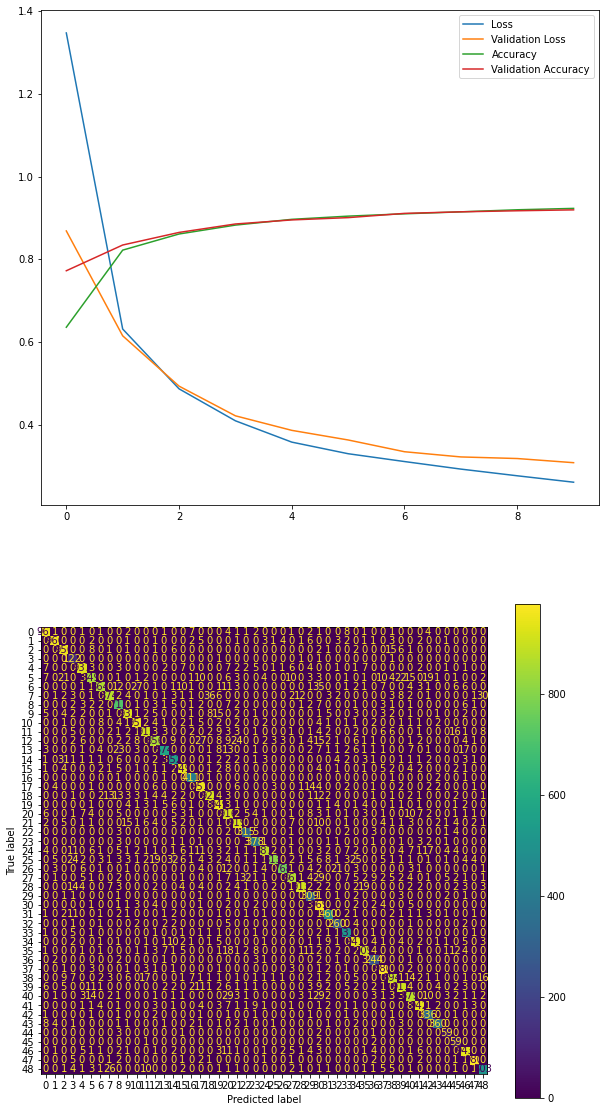

In [22]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[10, 20])    

    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(y_test, axis=1)

    cm = confusion_matrix(gt_idx, indexes)

    ax = fig.add_subplot(2, 1, 2)
    c = ConfusionMatrixDisplay(cm)
    c.plot(ax = ax)
    
    print(classification_report(gt_idx, indexes))
    
eval_model(model_cnn, history.history, train, train_y, test, test_y)

Overall results don't really vary from what we had - but this is (perhaps) a little clearer as to what is happening in the loss function